The shapes of train, test set are (42000, 28, 28), (28000, 28, 28).


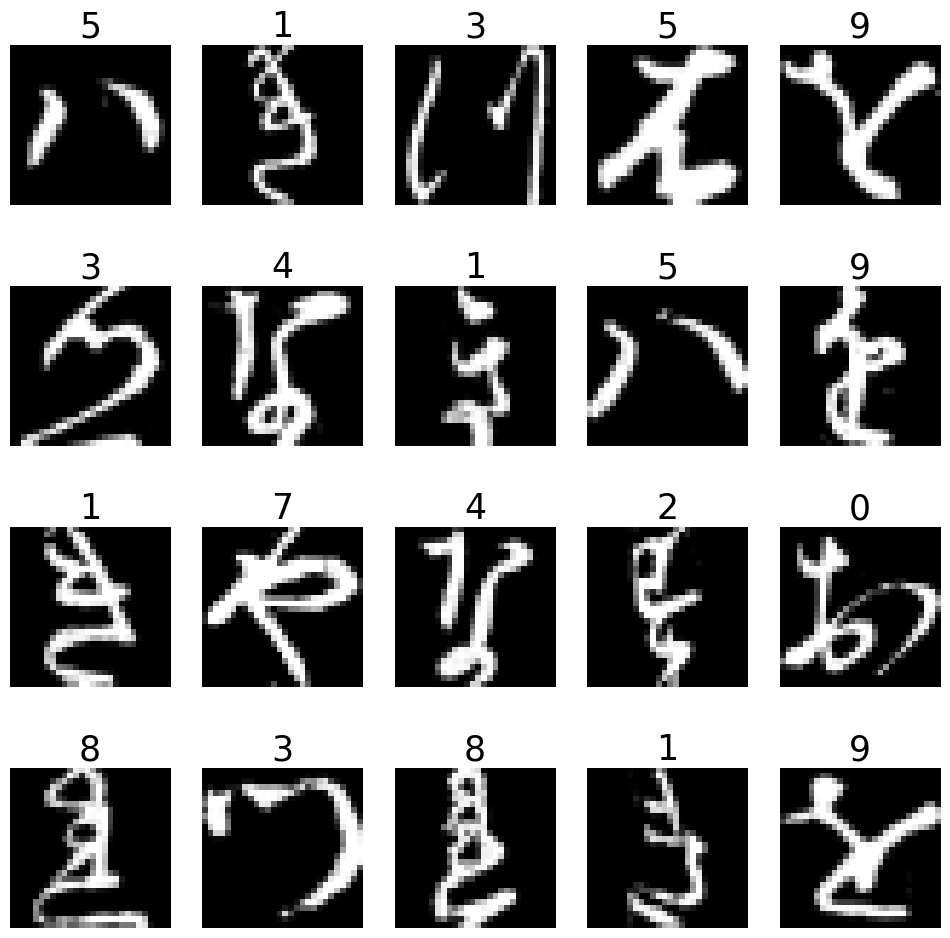

Shapes: (42000, 784), (28000, 784)

KNN accuracy no cv
0.955952380952381

RF accuracy no cv
0.9329761904761905

KNN accuracies cv
Fold  1
cv_acc:  0.9497619047619048
y_tst_acc:  0.9497619047619048

Fold  2
cv_acc:  0.9521428571428572
y_tst_acc:  0.9503571428571429

Fold  3
cv_acc:  0.9547619047619048
y_tst_acc:  0.9513095238095238

Fold  4
cv_acc:  0.9503571428571429
y_tst_acc:  0.9519047619047619

RF accuracies cv
Fold  1
cv_acc:  0.9195238095238095
y_tst_acc:  0.9275

Fold  2
cv_acc:  0.9286904761904762
y_tst_acc:  0.9235714285714286

Fold  3
cv_acc:  0.9282142857142858
y_tst_acc:  0.9279761904761905

Fold  4
cv_acc:  0.9210714285714285
y_tst_acc:  0.9252380952380952



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data

# the images for training
X_train = np.load('kmnist-train-imgs.npz')['X']

# the labels (category) for images
y_train = np.load('kmnist-train-labels.npz')['y']

# the images for competition (you want to use your model1 to predict the labels)
X_test = np.load('kmnist-test-imgs.npz')['X']

# verifying the shapes
print(f"The shapes of train, test set are {X_train.shape}, {X_test.shape}.")

fig, axes = plt.subplots(4,5, figsize=(12, 12))
axes = axes.reshape(-1)
np.random.seed(1)
idx = np.random.choice(X_train.shape[0], size=20)

for i in range(20):
    axes[i].axis('off') # hide the axes ticks
    axes[i].imshow(X_train[idx[i]], cmap = 'gray')
    axes[i].set_title(str(y_train[idx[i]]), color= 'black', fontsize=25)
plt.show()

# Flatten images
X_train = np.reshape(X_train, (-1, 784))
X_test = np.reshape(X_test, (-1, 784))
print(f"Shapes: {X_train.shape}, {X_test.shape}")
print()

# mini data set
# X_train = X_train[0:10000, :]
# y_train = y_train[0:10000]

# Preprocess X data
X_train = (X_train - np.min(X_train, axis=0))/(np.max(X_train, axis=0)-np.min(X_train, axis=0))
X_test = (X_test - np.min(X_test, axis=0))/(np.max(X_test, axis = 0)-np.min(X_test, axis=0))

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# creating pseudo-test data from training data using train_test_split function
X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.2)

# accuracy function
def acc(y1, y2):
    return np.mean(y1==y2)

# building models without cross-validation/k-fold
model1_nocv = KNeighborsClassifier(n_neighbors=3, weights='distance')
model1_nocv.fit(X_tr, y_tr)
y_pred1 = model1_nocv.predict(X_tst)
acc1 = acc(y_tst, y_pred1)

model2_nocv = RandomForestClassifier(n_estimators=250)
model2_nocv.fit(X_tr, y_tr)
y_pred2 = model2_nocv.predict(X_tst)
acc2 = acc(y_tst, y_pred2)

print('KNN accuracy no cv')
print(acc1)
print()
print('RF accuracy no cv')
print(acc2)
print()

# building models using cross-validation/k-fold
folds = KFold(n_splits = 4, shuffle=True)
models1 = []
models2 = []
test_accs1 = []
test_accs2 = []
cv_accs1 = []
cv_accs2 = []

for fold_, (tr_index, cv_index) in enumerate(folds.split(X_tr,y_tr)):


    X_tr_cv, X_cv = X_tr[tr_index], X_tr[cv_index]
    y_tr_cv, y_cv = y_tr[tr_index], y_tr[cv_index]

    model1 = KNeighborsClassifier(n_neighbors=3, weights = 'distance')
    model1.fit(X_tr_cv, y_tr_cv)
    models1.append(model1)

    cv_pred = model1.predict(X_cv)
    cv_acc = acc(y_cv, cv_pred)
    cv_accs1.append(cv_acc)

    y_pred = model1.predict(X_tst)
    y_tst_acc = acc(y_tst, y_pred)
    test_accs1.append(y_tst_acc)

    model2 = RandomForestClassifier(n_estimators=250, max_depth=100, min_samples_split=2, min_samples_leaf=1)
    model2.fit(X_tr_cv, y_tr_cv)
    models2.append(model2)

    cv_pred = model2.predict(X_cv)
    cv_acc = acc(y_cv, cv_pred)
    cv_accs2.append(cv_acc)

    y_pred = model2.predict(X_tst)
    y_tst_acc = acc(y_tst, y_pred)
    test_accs2.append(y_tst_acc)

print('KNN accuracies cv')
for i in range(4):
    print('Fold ', i+1)
    print('cv_acc: ', cv_accs1[i])
    print('y_tst_acc: ', test_accs1[i])
    print()

print('RF accuracies cv')
for i in range(4):
    print('Fold ', i+1)
    print('cv_acc: ', cv_accs2[i])
    print('y_tst_acc: ', test_accs2[i])
    print()

# choosing final models/making final preditcions based on which models performed the best against pseudo-test data
if np.argmax(test_accs1) > acc1:
    final_y_pred1 = models1[np.argmax(test_accs1)].predict(X_test)
else:
    final_y_pred1 = model1_nocv.predict(X_test)

solutions1 = np.zeros((X_test.shape[0], 2))
solutions1[:,0] = np.arange(1,X_test.shape[0]+1)
solutions1[:,1] = final_y_pred1
solutions1 = solutions1.astype(int)
np.savetxt("solutions1-ChristopherSullivan-GerardoRamirez-KNN.csv", solutions1, fmt='%s', header = 'Id,Category', delimiter = ',', comments='')

if np.argmax(test_accs2) > acc2:
    final_y_pred2 = models2[np.argmax(test_accs2)].predict(X_test)
else:
    final_y_pred2 = model2_nocv.predict(X_test)

solutions2 = np.zeros((X_test.shape[0], 2))
solutions1[:,0] = np.arange(1,X_test.shape[0]+1)
solutions1[:,1] = final_y_pred1
solutions1 = solutions2.astype(int)
np.savetxt("solutions2-ChristopherSullivan-GerardoRamirez-RF.csv", solutions2, fmt='%s', header = 'Id,Category', delimiter = ',', comments='')